In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
import seaborn

In [37]:
df = pd.read_csv('../data/Drug_Consumption.csv')

# remove ID column and semeron (fictitious drug introduced to identify over-claimers)
df = df.drop('ID', axis = 1)
df = df.drop('Semer', axis = 1)
df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0


In [38]:
print('There are', df.shape[0], 'rows and', str(df.shape[1]), 'columns.')

There are 1884 rows and 30 columns.


In [39]:
print(df.dtypes)

Age           object
Gender        object
Education     object
Country       object
Ethnicity     object
Nscore       float64
Escore       float64
Oscore       float64
AScore       float64
Cscore       float64
Impulsive    float64
SS           float64
Alcohol       object
Amphet        object
Amyl          object
Benzos        object
Caff          object
Cannabis      object
Choc          object
Coke          object
Crack         object
Ecstasy       object
Heroin        object
Ketamine      object
Legalh        object
LSD           object
Meth          object
Mushrooms     object
Nicotine      object
VSA           object
dtype: object


In [40]:
all_subs = set(df.columns[13:])

# used legal substance within in last WEEK or more frequent: 1, otherwise: 0
legal = {'Alcohol', 'Caff', 'Choc', 'Legalh', 'Nicotine'}
mapping_legal = {'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 0, 'CL4': 0, 'CL5': 1, 'CL6': 1}
for subs in legal:
    df = df.replace({subs: mapping_legal})

# used illegal substance within in last YEAR or more frequent: 1, otherwise: 0
illegal = all_subs - legal
# print(illegal)
mapping_illegal = {'CL0': 0, 'CL1': 0, 'CL2': 0, 'CL3': 1, 'CL4': 1, 'CL5': 1, 'CL6': 1}
for subs in illegal:
    df = df.replace({subs: mapping_legal})

df.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,Crack,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,VSA
0,25-34,M,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,0,0,0,0,0,0,0,0,0,0
1,35-44,M,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,0,0,0,0
2,18-24,F,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,0,0,0,0,0,0,0,0
3,35-44,F,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,0,0,0,0,0,0,0,0,0,0
4,65+,F,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,0,0,0,0,0,0,0,0,1,0


count    1884.000000
mean        0.787155
std         1.122277
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: NumIllegal, dtype: float64


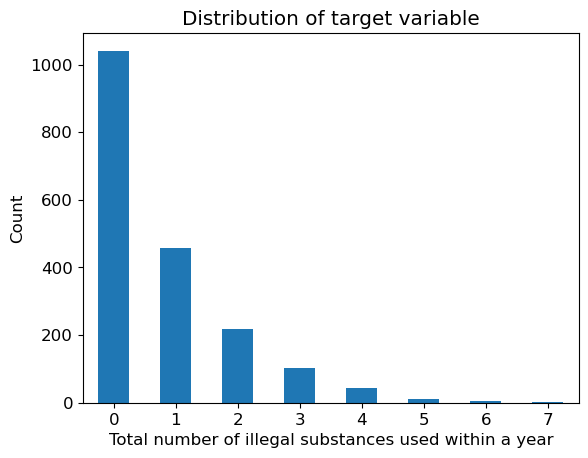

In [41]:
# legal substances -> features
# target variable: number of illegal substances used within a year
df['NumIllegal']= df[list(illegal)].sum(axis=1)
print(df['NumIllegal'].describe())

plt.rcParams.update({'font.size': 12})
df.value_counts(df['NumIllegal']).plot.bar()
plt.title('Distribution of target variable')
plt.xlabel('Total number of illegal substances used within a year')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')
plt.savefig('../figures/target_var_barplot.png', bbox_inches = "tight") 
plt.show()

In [42]:
# clean up feature matrix
df = df.drop(list(illegal), axis = 1)
df.columns

Index(['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore',
       'Escore', 'Oscore', 'AScore', 'Cscore', 'Impulsive', 'SS', 'Alcohol',
       'Caff', 'Choc', 'Legalh', 'Nicotine', 'NumIllegal'],
      dtype='object')

In [43]:
# split function
from sklearn.model_selection import train_test_split

def basic_split(X,y,train_size,val_size,test_size,random_state):
    
    # test the inputs
    if train_size + val_size + test_size != 1:
        raise ValueError('The sum of train_size, val_size, and test_size should be 1')
    if isinstance(random_state, int)==False:
        raise TypeError('random_state should be an integer')
        
    # perform basic split
    X_train, X_other, y_train, y_other = train_test_split(X,y,\
    train_size = train_size,random_state = random_state)
    
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,\
    train_size = val_size/(val_size+test_size),random_state = random_state)
    
    # test the outputs
    if X_train.shape[0] < train_size*X.shape[0]-1 or X_train.shape[0] > train_size*X.shape[0]+1:
        raise Exception("output size of X_train is incorrect!")
    if X_val.shape[0] < val_size*X.shape[0]-1 or X_val.shape[0] > val_size*X.shape[0]+1:
        raise Exception("output size of X_val is incorrect!")
    if X_test.shape[0] < test_size*X.shape[0]-1 or X_test.shape[0] > val_size*X.shape[0]+1:
        raise Exception("output size of X_test is incorrect!")
    if len(y_train) < train_size*len(y)-1 or len(y_train) > train_size*len(y)+1:
        raise Exception("output size of y_train is incorrect!")
    if len(y_val) < val_size*len(y)-1 or len(y_val) > val_size*len(y)+1:
        raise Exception("output size of y_val is incorrect!")
    if len(y_test) < test_size*len(y)-1 or len(y_test) > test_size*len(y)+1:
        raise Exception("output size of y_test is incorrect!")
    if X_train.shape[0] + X_val.shape[0] + X_test.shape[0] != X.shape[0]:
        raise Exception("The sum of X_train, X_val, and X_test should be 1.")
    if y_train.shape[0] + y_val.shape[0] + y_test.shape[0] != y.shape[0]:
        raise Exception("The sum of y_train, y_val, and y_test should be 1.")
                    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [44]:
# split dataset
y = df['NumIllegal']
X = df.loc[:, df.columns != 'NumIllegal']
train_size = 0.6
val_size = 0.2
test_size = 0.2
random_state = 6

X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X,y,train_size,val_size,test_size,random_state)

In [45]:
# ordinal encoding: age and education
ordinal_ftrs = ['Age','Education']
ordinal_cats = [['18-24', '25-34', '35-44', '45-54', '55-64', '65+'], \
                ['Left school before 16 years', 'Left school at 16 years', 'Left school at 17 years',\
                'Left school at 18 years', 'Some college or university, no certificate or degree',\
                'Professional certificate/ diploma', 'University degree', 'Masters degree', 'Doctorate degree']]
enc = OrdinalEncoder(categories = ordinal_cats) 

# fit on X_train
enc.fit(X_train[ordinal_ftrs])

# transform X_train
ordinal_train = enc.transform(X_train[ordinal_ftrs])
X_train[ordinal_ftrs] = ordinal_train

# transform X_val
ordinal_val = enc.transform(X_val[ordinal_ftrs])
X_val[ordinal_ftrs] = ordinal_val

# transform X_test
ordinal_test = enc.transform(X_test[ordinal_ftrs])
X_test[ordinal_ftrs] = ordinal_test

In [46]:
# one hot encoding: gender, country, ethnicity
categorical_ftrs = ['Gender','Country','Ethnicity']
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')

# fit on X_train
enc.fit(X_train[categorical_ftrs])
ohe_ftrs = enc.get_feature_names_out(categorical_ftrs)

# transform X_train
ohe_train = enc.transform(X_train[categorical_ftrs])
X_train = X_train.drop(categorical_ftrs, axis=1)
X_train[ohe_ftrs] = ohe_train

# transform X_val
ohe_val = enc.transform(X_val[categorical_ftrs])
X_val = X_val.drop(categorical_ftrs, axis=1)
X_val[ohe_ftrs] = ohe_val

# transform X_test
ohe_test = enc.transform(X_test[categorical_ftrs])
X_test = X_test.drop(categorical_ftrs, axis=1)
X_test[ohe_ftrs] = ohe_test

In [47]:
# normalize numerical features
std_ftrs = ['Nscore', 'Escore', 'Oscore', 'AScore', 'Cscore', 'Impulsive', 'SS']
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train[std_ftrs])
X_val_std = scaler.transform(X_val[std_ftrs])
X_test_std = scaler.transform(X_test[std_ftrs])

X_train = X_train.drop(std_ftrs, axis=1)
X_train[std_ftrs] = X_train_std

X_val = X_val.drop(std_ftrs, axis=1)
X_val[std_ftrs] = X_val_std

X_test = X_test.drop(std_ftrs, axis=1)
X_test[std_ftrs] = X_test_std

In [48]:
# transformed features and target variables
transformed_X = pd.concat([X_train, X_val, X_test])
transformed_X = transformed_X.sort_index()
transformed_df = pd.concat([transformed_X, y], axis = 1)
transformed_df.head()

,Age,Education,Alcohol,Caff,Choc,Legalh,Nicotine,Gender_F,Gender_M,Country_Australia,...,Ethnicity_Other,Ethnicity_White,Nscore,Escore,Oscore,AScore,Cscore,Impulsive,SS,NumIllegal
0,1.0,8.0,1,1,1,0,0,0.0,1.0,0.0,...,0.0,1.0,-0.692239,1.914594,1.435070,0.773373,-0.175158,-0.738979,-0.229059,0
1,2.0,5.0,1,1,0,0,0,0.0,1.0,0.0,...,0.0,1.0,-0.478585,0.791752,-0.849611,-1.601043,-1.030728,-1.432701,0.411168,0
2,0.0,7.0,0,1,0,0,0,1.0,0.0,0.0,...,0.0,1.0,-0.156151,-0.804295,-0.020834,0.603366,0.539012,-1.432701,-1.230107,0
3,2.0,8.0,0,1,1,0,0,1.0,0.0,0.0,...,0.0,1.0,0.739239,-1.623673,-0.453679,-0.285986,1.246872,-0.226249,-0.229059,0
4,5.0,3.0,0,1,0,0,1,1.0,0.0,0.0,...,0.0,1.0,-0.692239,-0.303288,-1.558131,2.048136,1.565611,-1.432701,-1.611549,0


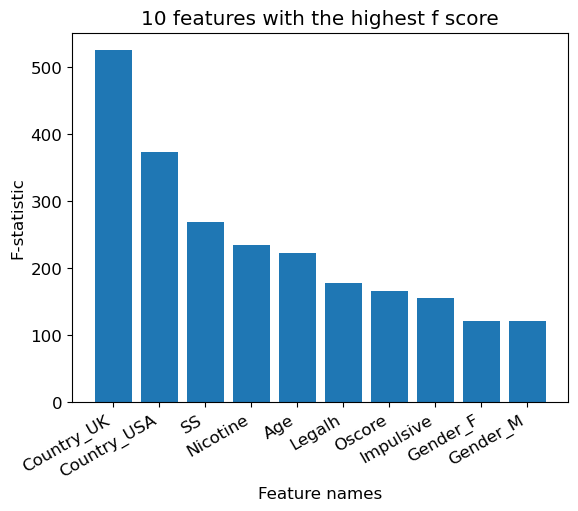

In [49]:
# linear correlation
transformed_y = transformed_df['NumIllegal']
transformed_X = transformed_df.loc[:, transformed_df.columns != 'NumIllegal']

f, p = f_regression(transformed_X,transformed_y)
top10_f_index = (np.argsort(f)[-10:])[::-1]
top10_f = f[top10_f_index]
c_names = transformed_X.columns[top10_f_index]

fig, ax = plt.subplots()
ax.bar(c_names,top10_f)

plt.xticks(rotation=30, ha='right')
plt.xlabel('Feature names')
plt.ylabel('F-statistic')
plt.title('10 features with the highest f score')
plt.savefig('../figures/top10_f.png', bbox_inches = "tight") 
plt.show()

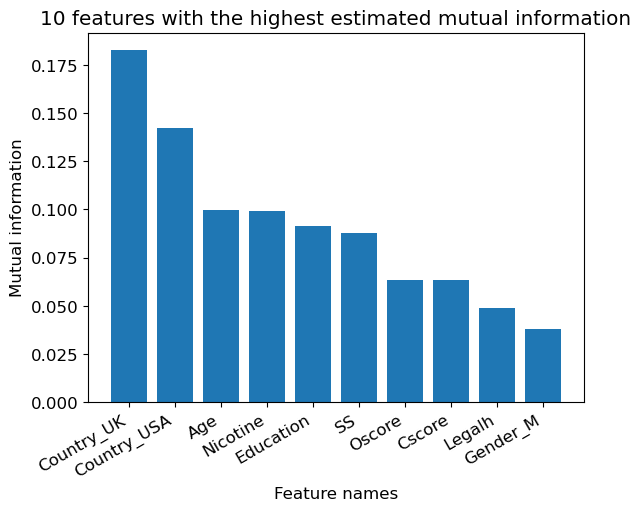

In [50]:
# non-linear correlation 
MI = mutual_info_regression(transformed_X,transformed_y, random_state=6)

top10_MI_index = (np.argsort(MI)[-10:])[::-1]
top10_MI = MI[top10_MI_index]
c_names = transformed_X.columns[top10_MI_index]

fig, ax = plt.subplots()
ax.bar(c_names,top10_MI)

plt.xticks(rotation=30, ha='right')
plt.xlabel('Feature names')
plt.ylabel('Mutual information')
plt.title('10 features with the highest estimated mutual information')
plt.savefig('../figures/top10_MI.png', bbox_inches = "tight") 
plt.show()

UK                     1043
USA                     557
Other                   118
Canada                   87
Australia                54
Republic of Ireland      20
New Zealand               5
Name: Country, dtype: int64


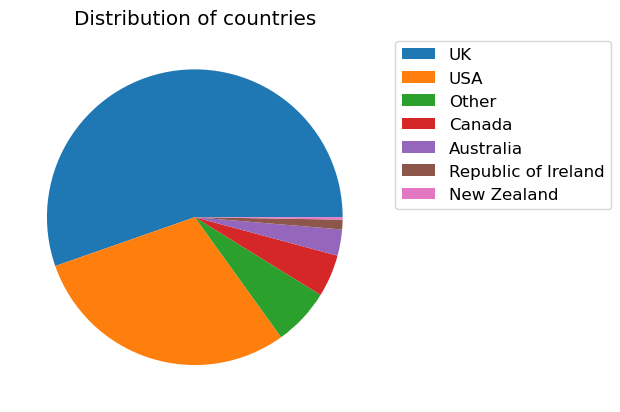

In [61]:
print(df['Country'].value_counts())
plot, texts = plt.pie(df['Country'].value_counts())

legends = ['UK', 'USA', 'Other', 'Canada', 'Australia', 'Republic of Ireland', 'New Zealand']
plt.legend(plot, legends, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of countries')
plt.savefig('../figures/country_pie.png', bbox_inches = "tight") 
plt.show()

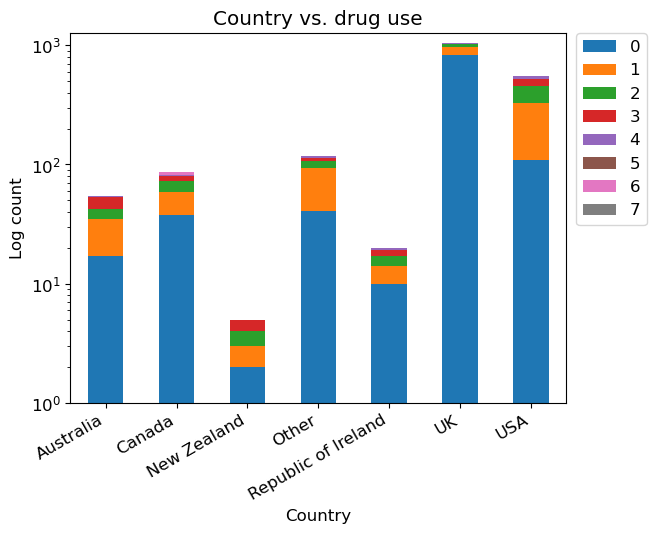

In [52]:
transformed_df_country = pd.concat([transformed_df,df['Country']], axis = 1)
Country_NumIllegal = transformed_df_country.groupby(['Country', 'NumIllegal']).size().unstack(fill_value=0)
Country_NumIllegal_norm = Country_NumIllegal.div(Country_NumIllegal.sum(axis=1),axis=0)
Country_NumIllegal.plot(kind='bar', stacked=True, log = True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.ylim(1,10**3.1)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Country')
plt.ylabel('Log count')
plt.title('Country vs. drug use')
plt.savefig('../figures/country_stacked.png', bbox_inches = "tight") 
plt.show()

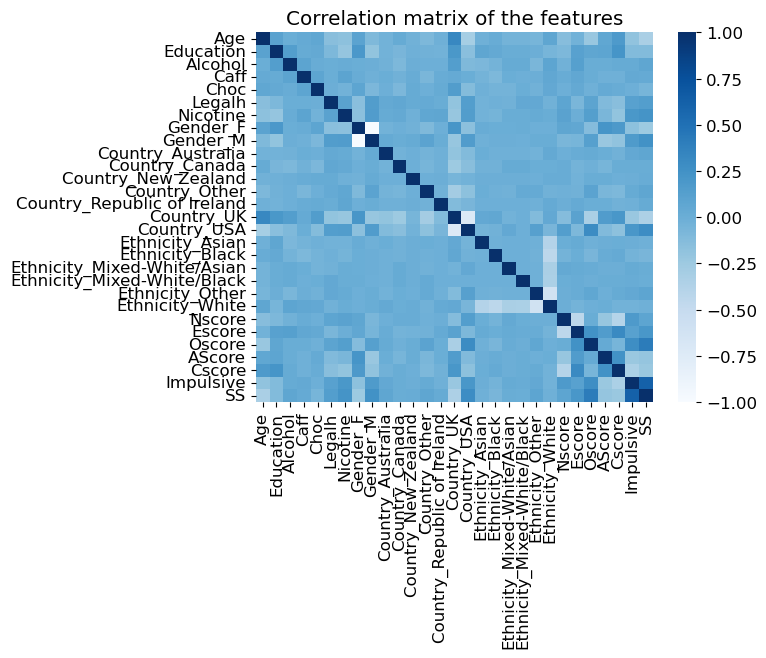

In [53]:
corr_matrix = transformed_X.corr(method ='pearson')
seaborn.heatmap(corr_matrix, cmap="Blues",xticklabels=True, yticklabels=True)

plt.title('Correlation matrix of the features')
plt.savefig('../figures/corr_matrix.png', bbox_inches = "tight") 
plt.show()

NumIllegal    0    1    2   3   4  5  6  7
Age                                       
0.0         192  235  118  63  21  8  5  1
1.0         287   87   60  29  15  1  1  1
2.0         252   67   27   4   4  1  0  0
3.0         221   49   14   7   2  1  0  0
4.0          74   18    0   0   1  0  0  0
5.0          15    3    0   0   0  0  0  0


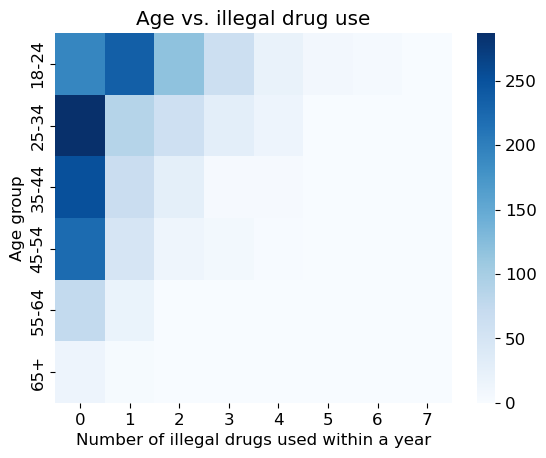

In [54]:
Age_NumIllegal = transformed_df.groupby(['Age','NumIllegal']).size().unstack(fill_value=0)
print(Age_NumIllegal)
yticks = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
seaborn.heatmap(Age_NumIllegal, cmap="Blues", yticklabels=yticks)

plt.title('Age vs. illegal drug use')
plt.ylabel('Age group')
plt.xlabel('Number of illegal drugs used within a year')
plt.savefig('../figures/heatmap_age.png', bbox_inches = "tight") 
plt.show()

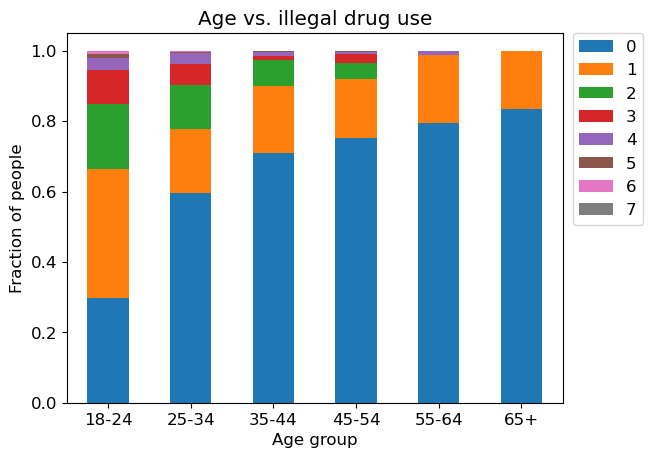

In [55]:
Age_NumIllegal_norm = Age_NumIllegal.div(Age_NumIllegal.sum(axis=1),axis=0)
xticks = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

Age_NumIllegal_norm.plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks([0, 1, 2, 3, 4, 5], ['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
plt.xticks(rotation=0, ha='center')
plt.xlabel('Age group')
plt.ylabel('Fraction of people')
plt.title('Age vs. illegal drug use')
plt.savefig('../figures/age_stacked.png', bbox_inches = "tight") 
plt.show()

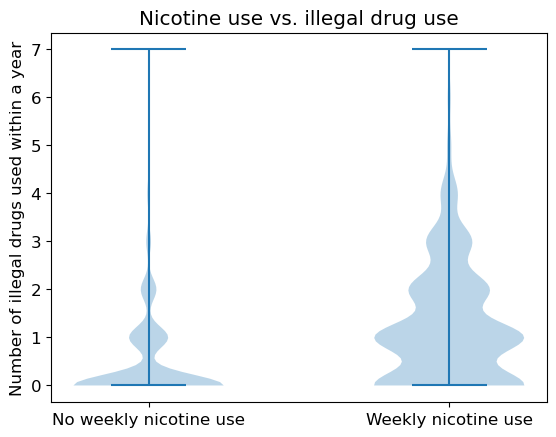

In [56]:
dataset = [transformed_df[transformed_df['Nicotine']==0]['NumIllegal'].values, 
           transformed_df[transformed_df['Nicotine']==1]['NumIllegal'].values]
plt.violinplot(dataset = dataset) 
plt.title('Nicotine use vs. illegal drug use')
plt.xticks([1,2],['No weekly nicotine use','Weekly nicotine use']) 
plt.ylabel('Number of illegal drugs used within a year')
plt.savefig('../figures/violinplot_nicotine.png', bbox_inches = "tight") 
plt.show()

NumIllegal    0   1   2   3   4  5  6  7
SS                                      
-2.161193    61   6   2   1   0  0  0  1
-1.611549    75   7   4   0   1  0  0  0
-1.230107   103  14   9   4   1  0  0  0
-0.883175   131  30   5   3   0  0  0  0
-0.550796   147  44  11   5   2  1  1  0
-0.229059   145  51  18   8   1  0  0  0
 0.077575   117  55  31   9   4  2  1  0
 0.411168   108  77  36  21   3  2  1  1
 0.788648    70  70  40  14  12  4  1  0
 1.265061    56  73  38  29  12  1  1  0
 1.988061    28  32  25   9   7  1  1  0


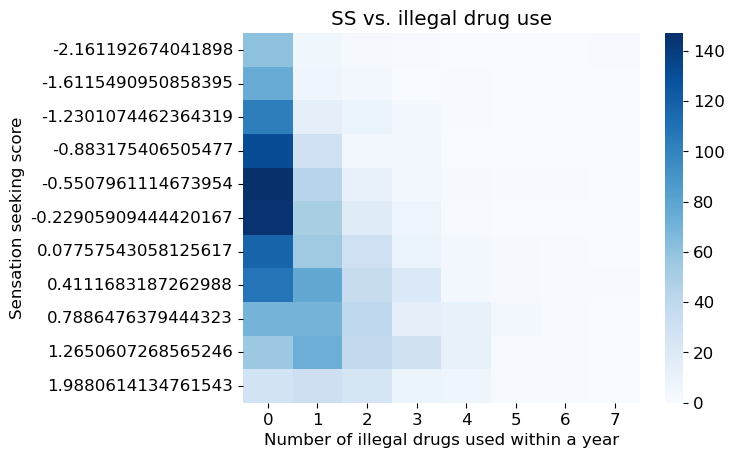

In [57]:
SS_NumIllegal = transformed_df.groupby(['SS','NumIllegal']).size().unstack(fill_value=0)
print(SS_NumIllegal)
seaborn.heatmap(SS_NumIllegal, cmap="Blues")

plt.title('SS vs. illegal drug use')
plt.ylabel('Sensation seeking score')
plt.xlabel('Number of illegal drugs used within a year')
plt.savefig('../figures/heatmap_SS.png', bbox_inches = "tight") 
plt.show()

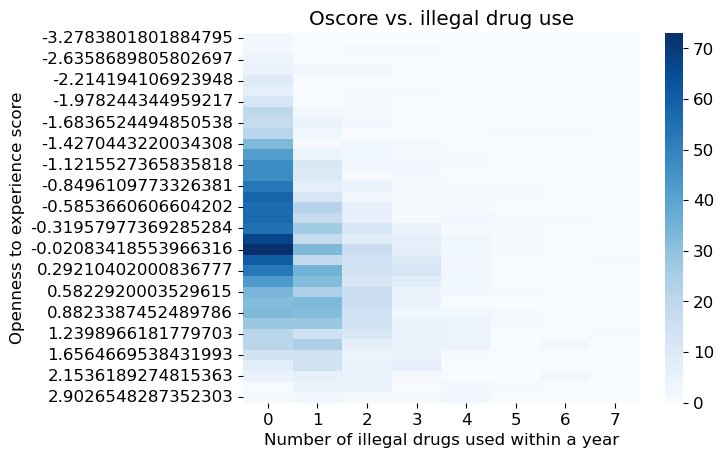

In [58]:
Os_NumIllegal = transformed_df.groupby(['Oscore','NumIllegal']).size().unstack(fill_value=0)
seaborn.heatmap(Os_NumIllegal, cmap="Blues")

plt.title('Oscore vs. illegal drug use')
plt.ylabel('Openness to experience score')
plt.xlabel('Number of illegal drugs used within a year')
plt.savefig('../figures/heatmap_Oscore.png', bbox_inches = "tight") 
plt.show()